# Single-point, semi-honest case

In this scenario, Alice and Bob are both assumed to be semi-honest, meaning that they will follow the protocol as specified, but they may try to learn more about the other party's input by analyzing the messages they receive. The goal is to compute the valuation of Bob's data point $x$, defined as the negative loss of the datapoint on Alice's model $M$.

In order to achieve this, Alice and Bob will run an MPC protocol, using the library CrypTen.



## Part 0: The setup

Before running the protocol, we need to define the model architecture (as an nn.module class) in model.py. We then need to save the model weights into `data/model.pth`, the data point $x$ into `data/data.pth` and the label into `data/lbl.pth`.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-0.9529412..0.7254902].


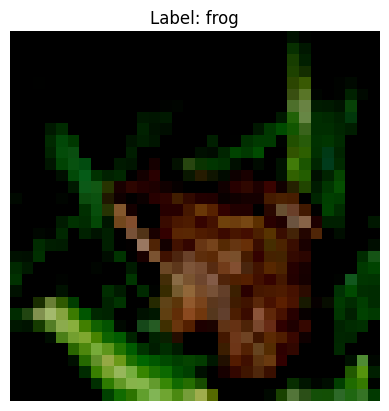

In [1]:
#First, we define Alice's model M. We assume a simple CNN model.
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim
import matplotlib.pyplot as plt

class LeNet(nn.Sequential):
    """
    Adaptation of LeNet that uses ReLU activations
    """

    # network architecture:
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 6, 5)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16 * 5 * 5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)
        self.act = nn.Softmax()

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 16 * 5 * 5)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        x = self.act(x)
        return x
    
model = LeNet()
#Save the model weights
torch.save(model.state_dict(), 'data/model.pth')

#Next, we define the data loader for CIFAR-10 dataset.
import torchvision
import torchvision.transforms as transforms

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=False,transform=transform)
data, lbl  = trainset[4]
classes = trainset.classes  # ['airplane', 'automobile', 'bird', ..., 'truck']
class_name = classes[lbl]

label_eye = torch.eye(10)
label = label_eye[lbl]

data = data.unsqueeze(0)  # Add batch dimension
torch.save(data, 'data/data.pth')
torch.save(label, 'data/lbl.pth')

# Since 'image' is a Torch tensor of shape (C, H, W),
# we need to permute the axes to (H, W, C) for display.
plt.imshow(data[0].permute(1, 2, 0))

# Add the class name as the title
plt.title(f"Label: {class_name}")
plt.axis('off')  # Hide axis ticks
plt.show()

#The variable model is Alice's model M, the variable data and lbl is Bob's contribution (x,y).

## Part 1: Model Inference and Valuation

Given that both parties are semi-honest, we can utilize the library CrypTen. CrypTen is an SMPC library that operates under semi-honest assumptions. 

In [2]:
import crypten
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

crypten.init()
crypten.common.serial.register_safe_class(LeNet)

#Define the rank of Alice and Bob
ALICE = 0
BOB = 1

#Encrypt model
model = LeNet() #Reload model 
model.load_state_dict(torch.load('./data/model.pth')) #Alice loads model weights
dummy_input = torch.empty(data.shape)
encrypted_model = crypten.nn.from_pytorch(model, dummy_input)
encrypted_model.encrypt(src=ALICE)
print("Model successfully encrypted:", encrypted_model.encrypted)

#Encrypt data and label
x,y = torch.load('data/data.pth'), torch.load('data/lbl.pth')
x = crypten.cryptensor(x)
y = crypten.cryptensor(y)

loss = crypten.nn.CrossEntropyLoss()

encrypted_model.eval()
output = encrypted_model(x)
valuation = -loss(output, y)

print("Valuation: ", valuation.get_plain_text())

/tmp/ipykernel_152309/1261688465.py:14: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('./data/model.pth')) #Alice loads model weights
/home/

Model successfully encrypted: True
Valuation:  tensor(-0.2315)


## Running in different processes

To run this in different process to better simulate two different parties, we can use the `multiprocessing` library in Python. Please check and run `python launcher.py` for the full example.
Here we benchmark the time needed.

In [3]:
import time

start_time = time.time()
!python launcher.py --multiprocess --world_size 2
end_time = time.time()

print(f"Time taken: {end_time - start_time} seconds")

INFO:root:==================
INFO:root:DistributedCommunicator with rank 1
INFO:root:==================
INFO:root:==================
INFO:root:DistributedCommunicator with rank 0
INFO:root:==================
INFO:root:World size = 2
INFO:root:World size = 2
/home/thomas/anaconda3/envs/sdv2/lib/python3.11/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)
/home/thomas/anaconda3/envs/sdv2/lib/python3.11/site-packages/crypten/__init__.py:64: RuntimeWarning: CrypTen is already initialized.
  warnings.warn("CrypTen is already initialized.", RuntimeWarning)
/home/thomas/anaconda3/envs/sdv2/lib/python3.11/site-packages/crypten/nn/onnx_converter.py:176: UserWarning: The given NumPy array is not writable, and PyTorch does not support non-writable tensors. This means writing to this tensor will result in undefined behavior. You may want to copy the array to protect its data or make it writable b